# 走神司机检测 PyTorch实现
本项目的数据来源是kaggle走神司机项目的[数据集](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data)。该数据集包含了10种类别的司机驾驶中的行为。为了简化处理，本项目已经将所有的数据下载并解压到跟本文件同目录，之后的所有操作建立在如下目录结构基础上：<br>
├── distracted_driver_detection.ipynb<br>
├── driver_imgs_list.csv<br>
└── imgs<br>
 &emsp;&emsp;├──test [79726 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── test<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp;└──train [22423 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c0 [2489 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c1 [2267 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c2 [2317 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c3 [2346 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c4 [2326 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c5 [2312 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c6 [2325 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c7 [2002 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c8 [1911 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;└── c9 [2129 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
├── cache [.h5 files] <br>
└── subm [.csv file]<br>

In [27]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import cv2
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sea
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## 数据探索

In [2]:
# 读取csv
driver_image_lists = pd.read_csv('driver_imgs_list.csv')
driver_image_lists.tail()

,subject,classname,img
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg
22423,p081,c9,img_9684.jpg


In [22]:
# 图片类别
classname_transfer = driver_image_lists['classname'].str[1:].astype('float32')
set(classname_transfer),len(set(classname_transfer))

({0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}, 10)

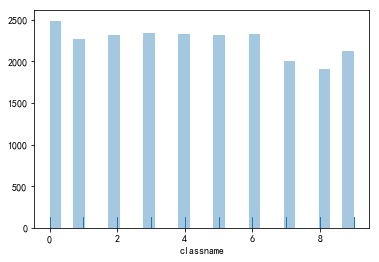

In [17]:
# 图片类别分布
sea.distplot(classname_transfer,kde=False,rug=True)

In [21]:
# 司机类别
subject_transfer = driver_image_lists['subject'].str[1:].astype('float32')
set(subject_transfer),len(set(subject_transfer))

({2.0,
  12.0,
  14.0,
  15.0,
  16.0,
  21.0,
  22.0,
  24.0,
  26.0,
  35.0,
  39.0,
  41.0,
  42.0,
  45.0,
  47.0,
  49.0,
  50.0,
  51.0,
  52.0,
  56.0,
  61.0,
  64.0,
  66.0,
  72.0,
  75.0,
  81.0},
 26)

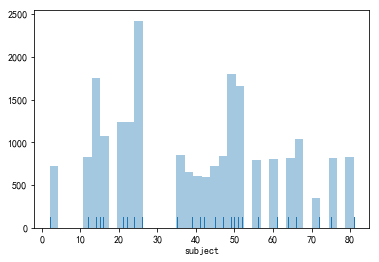

In [18]:
# 司机类别分布
sea.distplot(subject_transfer,kde=False,rug=True)

## 样本可视化

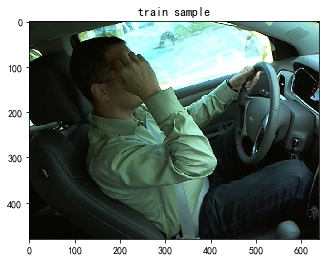

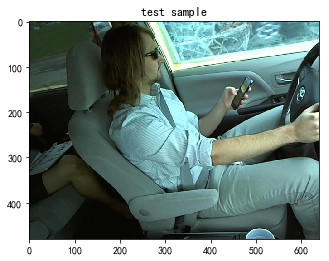

In [28]:
# 在训练集和测试集中分别选取一张图片进行展示
def show_sample(): 
    train_image_path = os.path.join('imgs','train','c0','*.jpg')
    test_image_path = os.path.join('imgs','test','test','*.jpg')
    train_files = glob.glob(train_image_path)
    test_files = glob.glob(test_image_path)
    train_file_index = 0
    test_file_index = 0
    for fl in train_files:
        if train_file_index == 0:
            img = cv2.imread(fl)
            RGB_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(RGB_img)
            plt.title('train sample')
            plt.show()
            break
    for fl in test_files:
        if test_file_index == 0:
            img = cv2.imread(fl)
            RGB_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(RGB_img)
            plt.title('test sample')
            plt.show()
            break
show_sample()

## Data Load

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [49]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
}
train_image_dir = os.path.join('imgs','train')
test_image_dir = os.path.join('imgs','test')
# 不带数据增强
train_image_datasets = datasets.ImageFolder(train_image_dir)
test_image_datasets = datasets.ImageFolder(test_image_dir)

In [41]:
# 训练集数据载入
train_dataloaders = torch.utils.data.DataLoader(train_image_datasets,batch_size=1,shuffle=True,num_workers=0)
class_names = train_image_datasets.classes
class_names

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [52]:
# 测试集数据载入
test_dataloaders = torch.utils.data.DataLoader(test_image_datasets,batch_size=1,shuffle=False,num_workers=0)

### 训练集、验证集划分

### 构建模型

### 训练、验证模型